# espagne.csv

# Data parsing

In [1]:
using PyPlot: pygui
pygui(true)
using Plots
pyplot()

Plots.PyPlotBackend()

In [2]:
include("import_all.jl")

write_solution_to_file (generic function with 1 method)

## Reading the instance

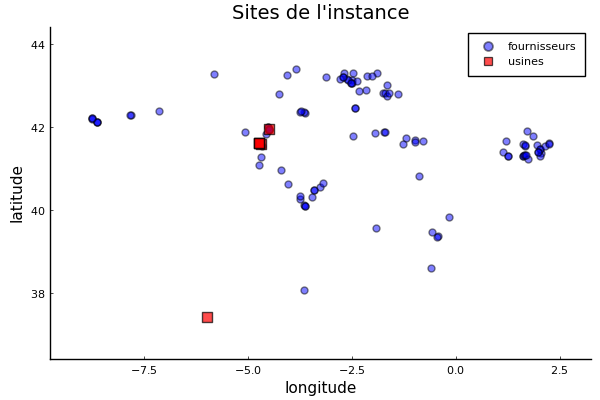

In [3]:
data_espagne = open(joinpath("..", "sujet", "espagne.csv")) do file
    readlines(file)
end

dims_espagne = lire_dimensions(data_espagne[1])

emballages_espagne = [lire_emballage(data_espagne[1+e], dims_espagne) for e = 1:dims_espagne.E]

usines_espagne = [lire_usine(data_espagne[1+dims_espagne.E+u], dims_espagne) for u = 1:dims_espagne.U]

fournisseurs_espagne = [
    lire_fournisseur(data_espagne[1+dims_espagne.E+dims_espagne.U+f], dims_espagne) for f = 1:dims_espagne.F
]

graphe_espagne = lire_graphe(data_espagne[1+dims_espagne.E+dims_espagne.U+dims_espagne.F+1:end], dims_espagne)

instance_espagne = lire_instance(joinpath("..", "sujet", "espagne.csv"))

plot_sites(instance_espagne)

# Solution

In [4]:
using JuMP
using Gurobi
import LightGraphs
const lg = LightGraphs

LightGraphs

## Func def

In [5]:
function create_graph(G_original, dims, us, fs, es, J_init, J_fin, e)
    U = dims.U
    F = dims.F
    J = J_fin - J_init + 1
    # J = dims.J
    cost_dispatch = dims.γ
    L = dims.L
    
    G = SimpleDiGraph((3 * U + 4 * F) * J + U + F + 1)
    capacity = zeros((3 * U + 4 * F) * J + U + F + 1, 
        (3 * U + 4 * F) * J + U + F + 1)
    cost_mat = zeros((3 * U + 4 * F) * J + U + F + 1, 
        (3 * U + 4 * F) * J + U + F + 1)
    
    for j = 1:J # for each day
        for u = 1:U # connect each u to each f stock
            for f = 1:F
                add_edge!(G, (j - 1) * (3 * U + 4 * F) + 3 * (u - 1) + 1, 
                    (j - 1) * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 1)
                capacity[(j - 1) * (3 * U + 4 * F) + 3 * (u - 1) + 1, 
                    (j - 1) * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 1] += Inf
                cost_mat[(j - 1) * (3 * U + 4 * F) + 3 * (u - 1) + 1, 
                    (j - 1) * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 1] += (G_original.d[u, U + f] * cost_dispatch + dims.ccam + dims.cstop) / L * es[e].l
            end
        end
        
        for f = 1:F
            # connect fictive u (carton) to each f consommation
            add_edge!(G, nv(G), (j - 1) * (3 * U + 4 * F) + 3 * U + 4 * f)
            #add_edge!(G, (j - 1) * (3 * U + 4 * F) + 3 * U + 4 * f, nv(G)) # cycle
            capacity[nv(G), (j - 1) * (3 * U + 4 * F) + 3 * U + 4 * f] += Inf
            #capacity[(j - 1) * (3 * U + 4 * F) + 3 * U + 4 * f, nv(G)] += Inf
            cost_mat[nv(G), (j - 1) * (3 * U + 4 * F) + 3 * U + 4 * f] += fs[f].cexc[e]
            # cost_mat[(j - 1) * (3 * U + 4 * F) + 3 * U + 4 * f, nv(G)] += fs[f].cexc[e]
        end
    end
    
    for j = 1:J
        for u = 1:U
            # connect u day j to two additional vertices
            add_edge!(G, (j - 1) * (3 * U + 4 * F) + 3 * (u - 1) + 1, 
                (j - 1) * (3 * U + 4 * F) + 3 * (u - 1) + 2)
            add_edge!(G, (j - 1) * (3 * U + 4 * F) + 3 * (u - 1) + 1, 
                (j - 1) * (3 * U + 4 * F) + 3 * (u - 1) + 3)
            
            capacity[(j - 1) * (3 * U + 4 * F) + 3 * (u - 1) + 1, 
                (j - 1) * (3 * U + 4 * F) + 3 * (u - 1) + 2] += us[u].r[e, j + J_init - 1]
            capacity[(j - 1) * (3 * U + 4 * F) + 3 * (u - 1) + 1, 
                (j - 1) * (3 * U + 4 * F) + 3 * (u - 1) + 3] += Inf
            
            cost_mat[(j - 1) * (3 * U + 4 * F) + 3 * (u - 1) + 1, 
                (j - 1) * (3 * U + 4 * F) + 3 * (u - 1) + 3] += us[u].cs[e]
            
            if j < J
                # connect two additional vertices to u day j+1
                add_edge!(G, (j - 1) * (3 * U + 4 * F) + 3 * (u - 1) + 2, 
                    j * (3 * U + 4 * F) + 3 * (u - 1) + 1)
                add_edge!(G, (j - 1) * (3 * U + 4 * F) + 3 * (u - 1) + 3, 
                    j * (3 * U + 4 * F) + 3 * (u - 1) + 1)
                
                capacity[(j - 1) * (3 * U + 4 * F) + 3 * (u - 1) + 2, 
                    j * (3 * U + 4 * F) + 3 * (u - 1) + 1] += us[u].r[e, j + J_init - 1]
                capacity[(j - 1) * (3 * U + 4 * F) + 3 * (u - 1) + 3, 
                    j * (3 * U + 4 * F) + 3 * (u - 1) + 1] += Inf
            end
        end
        
        for f = 1:F
            # connect f stock day j to two additional vertices
            add_edge!(G, (j - 1) * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 1, 
                (j - 1) * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 2)
            add_edge!(G, (j - 1) * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 1, 
                (j - 1) * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 3)
            
            capacity[(j - 1) * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 1, 
                (j - 1) * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 2] += fs[f].r[e, j + J_init - 1]
            capacity[(j - 1) * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 1, 
                (j - 1) * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 3] += Inf
            
            cost_mat[(j - 1) * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 1, 
                (j - 1) * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 3] += fs[f].cs[e]
            
            if j < J
                # connect each f stock to f consommation of the next day
                add_edge!(G, (j - 1) * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 1, j * (3 * U + 4 * F) + 3 * U + 4 * f)
                capacity[(j - 1) * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 1, j * (3 * U + 4 * F) + 3 * U + 4 * f] += Inf
                
                # connect two additional vertices to f day j+1
                add_edge!(G, (j - 1) * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 2, 
                    j * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 1)
                add_edge!(G, (j - 1) * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 3, 
                    j * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 1)
                
                capacity[(j - 1) * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 2, 
                    j * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 1] += fs[f].r[e, j + J_init - 1]
                capacity[(j - 1) * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 3, 
                    j * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 1] += Inf
            end
        end
    end
    
    # connect initial stock to the stock of day 1 (for each u)
    for u = 1:U
        add_edge!(G, (3 * U + 4 * F) * J + u, 3 * (u - 1) + 1)
        
        capacity[(3 * U + 4 * F) * J + u, 3 * (u - 1) + 1] += Inf
    end
    
    # connect initial stock to the stock of day 1 (for each f) & to the f consommation of day 1
    for f = 1:F
        add_edge!(G, (3 * U + 4 * F) * J + U + f, 3 * U + 4 * (f - 1) + 1)  
        add_edge!(G, (3 * U + 4 * F) * J + U + f, 3 * U + 4 * f)
        
        capacity[(3 * U + 4 * F) * J + U + f, 3 * U + 4 * (f - 1) + 1] += Inf
        capacity[(3 * U + 4 * F) * J + U + f, 3 * U + 4 * f] += Inf
    end
    
    return G, capacity, cost_mat
end

create_graph (generic function with 1 method)

In [6]:
# for a given e
function set_demand(dims, us, fs, J_init, J_fin, e) # b parameter
    U = dims.U
    F = dims.F
    J = J_fin - J_init + 1
    # J = dims.J
    demand = zeros((3 * U + 4 * F) * J + U + F + 1)
    
    for j = 1:J
        # for each u
        for u = 1:U
            demand[(j - 1) * (3 * U + 4 * F) + 3 * (u - 1) + 1] -= us[u].b⁺[e, j + J_init - 1]
        end
        
        # for each f consommation
        for f = 1:F
            demand[(j - 1) * (3 * U + 4 * F) + 3 * U + 4 * f] += fs[f].b⁻[e, j + J_init - 1]
        end
    end
    
    # for initial stock
    if J_init <= 1
        for u = 1:U
            demand[J * (3 * U + 4 * F) + u] -= us[u].s0[e]
        end
    
        for f = 1:F
            demand[J * (3 * U + 4 * F) + U + f] -= fs[f].s0[e]
        end
    else
        for u = 1:U
            demand[J * (3 * U + 4 * F) + u] -= us[u].s[e, J_init - 1]
        end
        
        for f = 1:F
            demand[J * (3 * U + 4 * F) + U + f] -= fs[f].s[e, J_init - 1]
        end
    end
    
    println(sum(demand))
    # additional vertices from day 1 to day J-1: b = 0
    # additional vertices of day J: b >= 0
    demand[(3 * U + 4 * F) * J + U + F + 1] += Inf # +Inf means that b is not fixed
    for u = 1:U
        demand[(J - 1) * (3 * U + 4 * F) + 3 * (u - 1) + 2] -= Inf # -Inf means b>=0
        demand[(J - 1) * (3 * U + 4 * F) + 3 * (u - 1) + 3] -= Inf
    end
    for f = 1:F
        demand[(J - 1) * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 2] -= Inf
        demand[(J - 1) * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 3] -= Inf
    end
    
    return demand
end

set_demand (generic function with 1 method)

In [7]:
function min_cost_flow(g, node_demand, edge_capacity, edge_cost, optimizer)
    m = JuMP.Model(optimizer)
    vtxs = vertices(g)
    
    source_nodes = [v for v in vtxs if node_demand[v] < 0 && node_demand[v] != -Inf]
    sink_nodes = [v for v in vtxs if node_demand[v] > 0 && node_demand[v] != Inf]
    
    idx_dict = Dict()
    ridx_dict = Dict()
    i = 1
    for e in lg.edges(g)
        idx_dict[i] = [src(e), dst(e)]
        ridx_dict[(src(e), dst(e))] = i
        i += 1
    end
    
    @variable(m, 0 <= f[i = 1:ne(g)] <= edge_capacity[idx_dict[i][1], idx_dict[i][2]], Int)
    @objective(m, Min, sum(f[i] * edge_cost[idx_dict[i][1], idx_dict[i][2]] for i = 1:ne(g)))
    # @variable(m, 0 <= f[i=vtxs, j=vtxs; (i,j) in lg.edges(g)] <= edge_capacity[i, j])
    # @objective(m, Min, sum(f[src(e),dst(e)] * edge_cost[src(e), dst(e)] for e in lg.edges(g)))

    for v in lg.vertices(g)
        if v in source_nodes
            @constraint(m,
                sum(f[ridx_dict[(v, vout)]] for vout in outneighbors(g, v)) - sum(f[ridx_dict[(vin, v)]] for vin in lg.inneighbors(g, v)) == -node_demand[v]
            )
        elseif v in sink_nodes
            @constraint(m,
                sum(f[ridx_dict[(vin, v)]] for vin in lg.inneighbors(g, v)) - sum(f[ridx_dict[(v, vout)]] for vout in outneighbors(g, v)) == node_demand[v]
            )
        else
            if node_demand[v] == -Inf
                @constraint(m, sum(f[ridx_dict[(vin, v)]] for vin in lg.inneighbors(g, v)) - sum(f[ridx_dict[(v, vout)]] for vout in outneighbors(g, v)) >= 0)
            elseif node_demand[v] != Inf
                @constraint(m,
                    sum(f[ridx_dict[(vin, v)]] for vin in lg.inneighbors(g, v)) == sum(f[ridx_dict[(v, vout)]] for vout in outneighbors(g, v))
                )
            end
        end
    end

    optimize!(m)
    ts = termination_status(m)
    result_flow = spzeros(nv(g), nv(g))
    if ts != MOI.OPTIMAL
        @warn "Problem does not have an optimal solution, status: $(ts)"
        return result_flow
    end
    for e in lg.edges(g)
        (i,j) = Tuple(e)
        result_flow[i,j] = JuMP.value(f[ridx_dict[(i,j)]])
    end
    return result_flow
    
end

min_cost_flow (generic function with 1 method)

In [8]:
function run_opt(g, dims, us, fs, es, J_init, J_fin, e, optimizer)
    g, capacity, cost_mat = create_graph(g, dims, us, fs, es, J_init, J_fin, e)
    demand = set_demand(dims, us, fs, J_init, J_fin, e)
    flow = min_cost_flow(g, demand, capacity, cost_mat, optimizer)
    return flow
end

run_opt (generic function with 1 method)

In [9]:
function read_flow(flow, U, F, J_init, J_fin)
    # create a U * F * J matrix (for a given e) for dispatching
    # create a U * J matrix (for a given e) for stockage
    # create a F * J matrix (for a given e) for stockage
    # create a F * J matrix (for a given e) for carton consommation
    J = J_fin - J_init + 1
    dispatch = zeros(U, F, J)
    stock_U = zeros(U, J)
    stock_F = zeros(F, J)
    consom_carton = zeros(F, J)
    for j = 1:J
        for u = 1:U
            for f = 1:F
                dispatch[u, f, j] += flow[(j - 1) * (3 * U + 4 * F) + 3 * (u - 1) + 1,
                    (j - 1) * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 1]
            end
        end
        
        for u = 1:U
            stock_U[u, j] = flow[(j - 1) * (3 * U + 4 * F) + 3 * (u - 1) + 1, (j - 1) * (3 * U + 4 * F) + 3 * (u - 1) + 2] +
            flow[(j - 1) * (3 * U + 4 * F) + 3 * (u - 1) + 1, (j - 1) * (3 * U + 4 * F) + 3 * (u - 1) + 3]
        end
        
        for f = 1:F
            stock_F[f, j] = flow[(j - 1) * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 1,
                (j - 1) * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 2] + 
            flow[(j - 1) * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 1,
                (j - 1) * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 3]
            
            consom_carton[f, j] = flow[size(flow)[1], (j - 1) * (3 * U + 4 * F) + 3 * U + 4 * f]
        end
    end
    
    return dispatch, consom_carton, stock_U, stock_F
end

read_flow (generic function with 1 method)

## Test

In [10]:
flow = run_opt(graphe_espagne, dims_espagne, usines_espagne, fournisseurs_espagne, emballages_espagne, 1, 21, 17, Gurobi.Optimizer)

-6.0
Academic license - for non-commercial use only - expires 2021-02-15
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 9989 rows, 28861 columns and 55349 nonzeros
Model fingerprint: 0xca8443b5
Variable types: 0 continuous, 28861 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [9e+00, 2e+02]
  Bounds range     [1e+00, 2e+02]
  RHS range        [1e+00, 7e+01]
Presolve removed 7574 rows and 19344 columns
Presolve time: 0.11s
Presolved: 2415 rows, 9517 columns, 18858 nonzeros
Variable types: 0 continuous, 9517 integer (2298 binary)

Root relaxation: objective 8.792547e+03, 313 iterations, 0.02 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    8792.5473077 8792.54731  0.00%     -    0s

Explored 0 n

9990×9990 SparseMatrixCSC{Float64,Int64} with 236 stored entries:
  [9876,   16]  =  9.0
  [16  ,   17]  =  5.0
  [10  ,   39]  =  9.0
  [16  ,   39]  =  8.0
  [9882,   42]  =  68.0
  [9901,  118]  =  1.0
  [9922,  199]  =  4.0
  [199 ,  200]  =  4.0
  [9990,  202]  =  4.0
  [10  ,  215]  =  5.0
  [9926,  218]  =  6.0
  [9951,  318]  =  1.0
  ⋮
  [8305, 8778]  =  1.0
  [8471, 8940]  =  29.0
  [8940, 8941]  =  29.0
  [8477, 8946]  =  7.0
  [8946, 8947]  =  7.0
  [8592, 9061]  =  1.0
  [9061, 9062]  =  1.0
  [8941, 9410]  =  29.0
  [9410, 9411]  =  29.0
  [8947, 9416]  =  7.0
  [9416, 9417]  =  7.0
  [9062, 9531]  =  1.0
  [9531, 9532]  =  1.0

In [11]:
disp, consom_carton, stock_U, stock_F = read_flow(flow, dims_espagne.U, dims_espagne.F, 1, 21)

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

...

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 5.0 0.0 … 7.0 7.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0])

In [12]:
sum(disp)

213.0

In [13]:
stock_U

6×21 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  …   0.0   0.0   0.0   0.0   0.0   0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0      0.0   0.0   0.0   0.0   0.0   0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0      0.0   0.0   0.0   0.0   0.0   0.0
 0.0  0.0  2.0  0.0  7.0  7.0  0.0     17.0  24.0  21.0  29.0  29.0  29.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0      0.0   0.0   0.0   0.0   0.0   0.0
 5.0  0.0  0.0  0.0  3.0  3.0  0.0  …   0.0   0.0   4.0   7.0   7.0   7.0

In [14]:
sum(usines_espagne[2].b⁺[7,:])

255

In [15]:
s = 0
for f = 1:dims_espagne.F
    s += fournisseurs_espagne[f].s0[7]
end
s

47

In [16]:
g, capacity, cost_mat = create_graph(graphe_espagne, dims_espagne, usines_espagne, fournisseurs_espagne, 1, 21, 3)

LoadError: MethodError: no method matching create_graph(::Graphe, ::NamedTuple{(:J, :U, :F, :E, :L, :γ, :ccam, :cstop),NTuple{8,Int64}}, ::Array{Usine,1}, ::Array{Fournisseur,1}, ::Int64, ::Int64, ::Int64)
Closest candidates are:
  create_graph(::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, !Matched::Any) at In[5]:1

In [17]:
sum(flow[nv(g),:])

LoadError: UndefVarError: g not defined

In [18]:
sum(consom_carton)

31.0

# First Fit Decreasing

In [19]:
function get_disp_all_E(graphe, dims, usines, fournisseurs, emballages)
    disp_all_E = zeros(dims.U,dims.F,dims.J,dims.E)
    for e in 1:dims.E
        flow = run_opt(graphe, dims, usines, fournisseurs, emballages, 1, dims.J, e, Gurobi.Optimizer)
        disp, consom_carton, stock_U, stock_F = read_flow(flow, dims.U, dims.F, 1, dims.J)
        disp_all_E[:,:,:,e] = disp[:,:,:]
    end
        return disp_all_E
end


get_disp_all_E (generic function with 1 method)

In [20]:
function get_F_list(u,j,dims,disp_all_E)
    FEflow_uj = Dict{Int64,Array{Int64}}()
    F_totalE = Dict{Int64, Int64}()
    F_list = []
    disp_all_E
    for f in 1:dims.F
        if sum(disp_all_E[u,f,j,:])>0
            FEflow_uj[f] = disp_all_E[u,f,j,:]
            F_totalE[f] = sum(disp_all_E[u,f,j,:])
            append!(F_list, f)
        end
    end
    return F_list
end

get_F_list (generic function with 1 method)

In [21]:
function get_items(u,f,j,disp_all_E,le,E)
    qe = disp_all_E[u,f,j,:]
    items = []
    for i in 1:E
        if qe[i] != 0
            for j in 1:qe[i]
                push!(items,le[i,:])
            end
        end
    end
    return items
end


get_items (generic function with 1 method)

In [22]:
function heur_FFD(L, items)
    n = length(items)
    order = sortperm(items,by=it->it[2], rev=true)
    bin_for_items = fill(-1,n)
    bin_space = []
    for i in order
        if length(bin_space) > 0
            for j in 1:length(bin_space)
                if items[i][2] <= bin_space[j]
                    bin_for_items[i] = j
                    bin_space[j] -= items[i][2]
                    break
                end
            end
        end

        if bin_for_items[i] < 0
            j = length(bin_space)
            bin_for_items[i] = j+1
            append!(bin_space, L-items[i][2])
        end
    end
    n_bins = length(bin_space)
    items_for_bins = []
    for n in 1:n_bins
        n_items = []
        for it in order
            if bin_for_items[it] == n
                push!(n_items, items[it])
            end
        end
        push!(items_for_bins,n_items)
    end
    return n_bins,bin_space,items_for_bins
end

heur_FFD (generic function with 1 method)

In [23]:
function get_rest_vol(rest_items_f)
    f_rest_vol = 0
    for i in 1:length(rest_items_f)
        f_rest_vol += sum(rest_items_f[i][2])
    end
    return f_rest_vol
end

get_rest_vol (generic function with 1 method)

In [24]:
function count_items(items)
    items_count = Dict{Int64, Int64}()
    for it in items
        if it[1] in collect(keys(items_count))
            items_count[it[1]] += 1
        else
            items_count[it[1]] = 1
        end
    end
    return collect(items_count)
end

count_items (generic function with 1 method)

In [25]:
function count_items_list(items)
    items_count = Dict{Int64, Int64}()
    for i in 1:length(items)
        if items[i][1] in collect(keys(items_count))
            items_count[items[i][1]] += 1
        else
            items_count[items[i][1]] = 1
        end
    end
    return collect(items_count)
end

count_items_list (generic function with 1 method)

In [26]:
# calculate first big f

function get_route_1f(camion_space, camion_stop, u,j,F_list, dims,disp_all_E, le)
    rest_items = Dict{Int64,Array}()
    fini_F_list = []
    for f in F_list
        items = get_items(u,f,j,disp_all_E,le,dims.E)
        n_bins,bin_space,items_for_bins = heur_FFD(dims.L, items)
        for n in 1:n_bins
            if bin_space[n] > dims.L *0.5
                if f in collect(keys(rest_items))
                    append!(rest_items[f],items_for_bins[n])
                else
                    rest_items[f] = items_for_bins[n]
                end
            else
#                 sol_line = write_sol_route_1f(r, u, j, f, items_for_bins[n])
#                 r += 1
#                 push!(sol_string,sol_line)
                append!(camion_space, bin_space[n])
                push!(camion_stop, [f=>[items_for_bins[n]],])
            end
        end
    end
    return rest_items,camion_space, camion_stop
end

get_route_1f (generic function with 1 method)

In [27]:
function f_heur_FFD(L, items, f, camion_space, camion_stop)
    n = length(items)
    order = sortperm(items,by=it->it[2], rev=true)
    bin_for_items = fill(-1,n)
    for i in order
        if length(camion_space) > 0
            for j in 1:length(camion_space)
                if length(camion_stop[j]) < 4 && items[i][2] <= camion_space[j]
                    for st in length(camion_stop[j])
                        if camion_stop[j][st][1] == f
                            push!(camion_stop[j][st][2], items[i])
                        else
                            append!(camion_stop[j], [f=>[items[i],],])
                        end
                    end
                    bin_for_items[i] = j
                    camion_space[j] -= items[i][2]
                    break 
                end
            end
        end

        if bin_for_items[i] < 0
            j = length(camion_space)
            push!(camion_stop, [f=>[items[i],],])
            append!(camion_space, L-items[i][2])
        end
    end
    return camion_space, camion_stop
end

f_heur_FFD (generic function with 1 method)

In [43]:
# routing for rest f

function get_route_multi_f(u,j,rest_items,camion_space,camion_stop,dims,usines,fournisseurs,graphe)
    point_depart = usines[u].v
    rest_F_open = collect(keys(rest_items))
    while length(rest_F_open)>0
        rest_F_open = sort(rest_F_open, by=f->graphe.d[point_depart, fournisseurs[f].v])
        f = rest_F_open[1]
        items = rest_items[f]
        camion_space, camion_stop = f_heur_FFD(dims.L, items, f, camion_space, camion_stop)
        point_depart = fournisseurs[f].v
        popfirst!(rest_F_open)
    end
    return camion_space, camion_stop
end

get_route_multi_f (generic function with 2 methods)

In [29]:
function write_sol_route_multi_f(r, u, j, camion_stop, sol_string)
    sol_line = ""
    for c in 1:length(camion_stop)
        sol_line = "r " * string(r-1) * " j "* string(j-1) * " x " * string(1) * " u " * string(u-1)
        sol_line = sol_line * " F " * string(length(camion_stop[c]))
        for i in 1:length(camion_stop[c])
            f = camion_stop[c][i][1]
            sol_line = sol_line * " f " * string(f-1)
            items_nb = count_items_list(camion_stop[c][i][2][1])
            for i in 1:length(items_nb)
                for e in 1:dims.E
                    if e == items_nb[i][1]
                        q_e = items_nb[i][2]
                    else
                        q_e = 0
                    end
                    sol_line = sol_line * " e " * string(e-1) * " q " * string(q_e)
                end
            end
        end
        push!(sol_string,sol_line)
        r += 1
        sol_line = ""
    end
    return sol_string, r
end

write_sol_route_multi_f (generic function with 1 method)

In [30]:
function run_heur_route(disp_all_E, graphe, dims, usines, fournisseurs, emballages)
    le = Matrix(undef, dims.E, 2)
    for e in 1: dims.E
        le[e,1] = emballages[e].e
        le[e, 2] = emballages[e].l
    end
    sol_string = Array{String,1}(undef,1)
    r = 1
    for u in 1:dims.U
        for j in 1:dims.J
            camion_space = []
            camion_stop = []
            F_list = get_F_list(u,j,dims,disp_all_E)
            rest_items,camion_space, camion_stop = get_route_1f(camion_space, camion_stop, u,j,F_list, dims, disp_all_E, le)
            camion_space, camion_stop = get_route_multi_f(u,j,rest_items,camion_space,camion_stop,dims,usines,fournisseurs,graphe)
            sol_string, r = write_sol_route_multi_f(r, u, j, camion_stop, sol_string)
        end
    end
    
    sol_string[1] = "R " * string(length(sol_string)-1)
    
    return sol_string
end

run_heur_route (generic function with 1 method)

In [39]:
dims = dims_espagne
graphe = graphe_espagne
usines = usines_espagne
fournisseurs = fournisseurs_espagne
emballages = emballages_espagne
disp_all_E = get_disp_all_E(graphe, dims, usines, fournisseurs, emballages)

23.0
Academic license - for non-commercial use only - expires 2021-02-15
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 9989 rows, 28861 columns and 55349 nonzeros
Model fingerprint: 0x1bd71ef0
Variable types: 0 continuous, 28861 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [7e+00, 1e+02]
  Bounds range     [1e+00, 3e+01]
  RHS range        [1e+00, 8e+00]
Presolve removed 7574 rows and 19264 columns
Presolve time: 0.11s
Presolved: 2415 rows, 9597 columns, 18941 nonzeros
Variable types: 0 continuous, 9597 integer (2266 binary)

Root relaxation: objective 7.299423e+03, 431 iterations, 0.03 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    7299.4230769 7299.42308  0.00%     -    0s

Explored 0 n

-168.0
Academic license - for non-commercial use only - expires 2021-02-15
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 9989 rows, 28861 columns and 55349 nonzeros
Model fingerprint: 0x96edd9e4
Variable types: 0 continuous, 28861 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e+00, 5e+01]
  Bounds range     [1e+00, 3e+02]
  RHS range        [1e+00, 6e+01]
Presolve removed 7513 rows and 12074 columns
Presolve time: 0.28s
Presolved: 2476 rows, 16787 columns, 33361 nonzeros
Variable types: 0 continuous, 16787 integer (2424 binary)

Root relaxation: objective 5.551849e+03, 2795 iterations, 0.24 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    5551.8492308 5551.84923  0.00%     -    0s

Explore

Academic license - for non-commercial use only - expires 2021-02-15
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 9989 rows, 28861 columns and 55349 nonzeros
Model fingerprint: 0xbbc0fd97
Variable types: 0 continuous, 28861 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+01, 2e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective 0.0000000

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 8 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-04)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%

User-callback calls 21, time in user-callback 0.00 sec
-6.0
Academic license - for non-commercial use only - expires 2021-02-15
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (win64)
Thread coun

18.0
Academic license - for non-commercial use only - expires 2021-02-15
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 9989 rows, 28861 columns and 55349 nonzeros
Model fingerprint: 0xd634f203
Variable types: 0 continuous, 28861 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [9e+00, 2e+02]
  Bounds range     [1e+00, 3e+01]
  RHS range        [1e+00, 2e+01]
Presolve removed 7560 rows and 16837 columns
Presolve time: 0.22s
Presolved: 2429 rows, 12024 columns, 23767 nonzeros
Variable types: 0 continuous, 12024 integer (3398 binary)

Root relaxation: objective 1.207909e+04, 676 iterations, 0.03 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    12079.086538 12079.0865  0.00%     -    0s

Explored 0

6×113×21×27 Array{Float64,4}:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  2.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 2, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

[:

In [44]:

sol_string = run_heur_route(disp_all_E, graphe, dims, usines, fournisseurs, emballages)

open(joinpath("..", "sujet", "espagne sol.txt"), "w") do file
    for ln in sol_string
        write(file, ln) 
        write(file, '\n') 
    end
end

routes_espagne = [lire_route(sol_string[1+r]) for r = 1:length(sol_string)-1]
routes_espagne

902-element Array{Route,1}:
 Route 1
   Jour 1
   Nb de camions 1
   Usine de départ 1
   Nb d'arrêts 1
   Stop 1
      Fournisseur 65
      Livraison [0, 0, 0, 0, 0, 0, 0, 20, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 Route 2
   Jour 1
   Nb de camions 1
   Usine de départ 1
   Nb d'arrêts 4
   Stop 1
      Fournisseur 76
      Livraison [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
   Stop 2
      Fournisseur 14
      Livraison [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
   Stop 3
      Fournisseur 65
      Livraison [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [45]:
instance_solved = lire_solution(instance_espagne, joinpath("..", "sujet", "espagne sol.txt"))


Instance
   Nombre de jours: 21
   Nombre d'usines: 6
   Nombre de fournisseurs: 113
   Nombre de types d'emballages: 27
   Nombre de routes: 902

In [46]:
feasibility(instance_solved)

LoadError: DimensionMismatch("dimensions must match: a has dims (Base.OneTo(27),), b has dims (Base.OneTo(54),), mismatch at 1")

In [47]:
totalcost = cost(instance_solved, verbose=true)

Usine 1
   Jour 1
      Coût stock: 167
   Jour 2
      Coût stock: 165
   Jour 3
      Coût stock: 165
   Jour 4
      Coût stock: 165
   Jour 5
      Coût stock: 165
   Jour 6
      Coût stock: 165
   Jour 7
      Coût stock: 165
   Jour 8
      Coût stock: 165
   Jour 9
      Coût stock: 165
   Jour 10
      Coût stock: 225
   Jour 11
      Coût stock: 225
   Jour 12
      Coût stock: 225
   Jour 13
      Coût stock: 223
   Jour 14
      Coût stock: 223
   Jour 15
      Coût stock: 223
   Jour 16
      Coût stock: 223
   Jour 17
      Coût stock: 223
   Jour 18
      Coût stock: 223
   Jour 19
      Coût stock: 223
   Jour 20
      Coût stock: 223
   Jour 21
      Coût stock: 223
Usine 2
   Jour 1
      Coût stock: 2114
   Jour 2
      Coût stock: 7526
   Jour 3
      Coût stock: 17989
   Jour 4
      Coût stock: 34456
   Jour 5
      Coût stock: 42153
   Jour 6
      Coût stock: 40078
   Jour 7
      Coût stock: 37876
   Jour 8
      Coût stock: 50642
   Jour 9
      Coût stock: 66

   Jour 2
      Coût stock: 0
      Coût expédition: 1540
      Coût total: 1540
   Jour 3
      Coût stock: 0
      Coût expédition: 700
      Coût total: 700
   Jour 4
      Coût stock: 0
      Coût expédition: 700
      Coût total: 700
   Jour 5
      Coût stock: 0
      Coût expédition: 700
      Coût total: 700
   Jour 6
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 7
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 8
      Coût stock: 0
      Coût expédition: 1540
      Coût total: 1540
   Jour 9
      Coût stock: 0
      Coût expédition: 700
      Coût total: 700
   Jour 10
      Coût stock: 0
      Coût expédition: 910
      Coût total: 910
   Jour 11
      Coût stock: 0
      Coût expédition: 700
      Coût total: 700
   Jour 12
      Coût stock: 0
      Coût expédition: 700
      Coût total: 700
   Jour 13
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 14
      Coût stock: 0
      Coût expédition: 0


   Jour 1
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 2
      Coût stock: 0
      Coût expédition: 1460
      Coût total: 1460
   Jour 3
      Coût stock: 0
      Coût expédition: 1710
      Coût total: 1710
   Jour 4
      Coût stock: 0
      Coût expédition: 1710
      Coût total: 1710
   Jour 5
      Coût stock: 0
      Coût expédition: 1710
      Coût total: 1710
   Jour 6
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 7
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 8
      Coût stock: 0
      Coût expédition: 1350
      Coût total: 1350
   Jour 9
      Coût stock: 0
      Coût expédition: 1700
      Coût total: 1700
   Jour 10
      Coût stock: 0
      Coût expédition: 1370
      Coût total: 1370
   Jour 11
      Coût stock: 0
      Coût expédition: 1250
      Coût total: 1250
   Jour 12
      Coût stock: 0
      Coût expédition: 1250
      Coût total: 1250
   Jour 13
      Coût stock: 0
      Coût e

      Coût stock: 0
      Coût expédition: 240
      Coût total: 240
   Jour 3
      Coût stock: 0
      Coût expédition: 390
      Coût total: 390
   Jour 4
      Coût stock: 0
      Coût expédition: 360
      Coût total: 360
   Jour 5
      Coût stock: 0
      Coût expédition: 360
      Coût total: 360
   Jour 6
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 7
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 8
      Coût stock: 0
      Coût expédition: 360
      Coût total: 360
   Jour 9
      Coût stock: 0
      Coût expédition: 240
      Coût total: 240
   Jour 10
      Coût stock: 0
      Coût expédition: 510
      Coût total: 510
   Jour 11
      Coût stock: 0
      Coût expédition: 390
      Coût total: 390
   Jour 12
      Coût stock: 0
      Coût expédition: 390
      Coût total: 390
   Jour 13
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 14
      Coût stock: 0
      Coût expédition: 0
      Coût tot

      Coût total: 2040
   Jour 3
      Coût stock: 0
      Coût expédition: 1840
      Coût total: 1840
   Jour 4
      Coût stock: 0
      Coût expédition: 2050
      Coût total: 2050
   Jour 5
      Coût stock: 0
      Coût expédition: 2140
      Coût total: 2140
   Jour 6
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 7
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 8
      Coût stock: 0
      Coût expédition: 1790
      Coût total: 1790
   Jour 9
      Coût stock: 0
      Coût expédition: 1340
      Coût total: 1340
   Jour 10
      Coût stock: 0
      Coût expédition: 1490
      Coût total: 1490
   Jour 11
      Coût stock: 0
      Coût expédition: 1700
      Coût total: 1700
   Jour 12
      Coût stock: 0
      Coût expédition: 1800
      Coût total: 1800
   Jour 13
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 14
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 15
      Coût st

   Jour 17
      Coût stock: 0
      Coût expédition: 210
      Coût total: 210
   Jour 18
      Coût stock: 0
      Coût expédition: 210
      Coût total: 210
   Jour 19
      Coût stock: 0
      Coût expédition: 210
      Coût total: 210
   Jour 20
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 21
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
Fournisseur 29
   Jour 1
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 2
      Coût stock: 0
      Coût expédition: 1838
      Coût total: 1838
   Jour 3
      Coût stock: 0
      Coût expédition: 1718
      Coût total: 1718
   Jour 4
      Coût stock: 0
      Coût expédition: 2678
      Coût total: 2678
   Jour 5
      Coût stock: 0
      Coût expédition: 1718
      Coût total: 1718
   Jour 6
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 7
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 8
      Coût stock: 0
      Coût exp

      Coût expédition: 420
      Coût total: 420
   Jour 16
      Coût stock: 0
      Coût expédition: 420
      Coût total: 420
   Jour 17
      Coût stock: 0
      Coût expédition: 420
      Coût total: 420
   Jour 18
      Coût stock: 0
      Coût expédition: 420
      Coût total: 420
   Jour 19
      Coût stock: 0
      Coût expédition: 420
      Coût total: 420
   Jour 20
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 21
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
Fournisseur 35
   Jour 1
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 2
      Coût stock: 0
      Coût expédition: 420
      Coût total: 420
   Jour 3
      Coût stock: 0
      Coût expédition: 540
      Coût total: 540
   Jour 4
      Coût stock: 0
      Coût expédition: 540
      Coût total: 540
   Jour 5
      Coût stock: 0
      Coût expédition: 540
      Coût total: 540
   Jour 6
      Coût stock: 0
      Coût expédition: 0
      Coût total: 

   Jour 15
      Coût stock: 0
      Coût expédition: 790
      Coût total: 790
   Jour 16
      Coût stock: 0
      Coût expédition: 790
      Coût total: 790
   Jour 17
      Coût stock: 0
      Coût expédition: 910
      Coût total: 910
   Jour 18
      Coût stock: 0
      Coût expédition: 910
      Coût total: 910
   Jour 19
      Coût stock: 0
      Coût expédition: 910
      Coût total: 910
   Jour 20
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 21
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
Fournisseur 40
   Jour 1
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 2
      Coût stock: 0
      Coût expédition: 240
      Coût total: 240
   Jour 3
      Coût stock: 0
      Coût expédition: 240
      Coût total: 240
   Jour 4
      Coût stock: 0
      Coût expédition: 240
      Coût total: 240
   Jour 5
      Coût stock: 0
      Coût expédition: 240
      Coût total: 240
   Jour 6
      Coût stock: 0
      Coût e

      Coût total: 0
   Jour 7
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 8
      Coût stock: 0
      Coût expédition: 420
      Coût total: 420
   Jour 9
      Coût stock: 0
      Coût expédition: 210
      Coût total: 210
   Jour 10
      Coût stock: 0
      Coût expédition: 210
      Coût total: 210
   Jour 11
      Coût stock: 0
      Coût expédition: 210
      Coût total: 210
   Jour 12
      Coût stock: 0
      Coût expédition: 210
      Coût total: 210
   Jour 13
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 14
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 15
      Coût stock: 0
      Coût expédition: 420
      Coût total: 420
   Jour 16
      Coût stock: 0
      Coût expédition: 420
      Coût total: 420
   Jour 17
      Coût stock: 0
      Coût expédition: 420
      Coût total: 420
   Jour 18
      Coût stock: 0
      Coût expédition: 420
      Coût total: 420
   Jour 19
      Coût stock: 0
    

      Coût stock: 0
      Coût expédition: 840
      Coût total: 840
   Jour 12
      Coût stock: 0
      Coût expédition: 840
      Coût total: 840
   Jour 13
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 14
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 15
      Coût stock: 0
      Coût expédition: 210
      Coût total: 210
   Jour 16
      Coût stock: 0
      Coût expédition: 210
      Coût total: 210
   Jour 17
      Coût stock: 0
      Coût expédition: 330
      Coût total: 330
   Jour 18
      Coût stock: 0
      Coût expédition: 330
      Coût total: 330
   Jour 19
      Coût stock: 0
      Coût expédition: 330
      Coût total: 330
   Jour 20
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 21
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
Fournisseur 52
   Jour 1
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 2
      Coût stock: 0
      Coût expédition: 1677

      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 7
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 8
      Coût stock: 0
      Coût expédition: 210
      Coût total: 210
   Jour 9
      Coût stock: 0
      Coût expédition: 210
      Coût total: 210
   Jour 10
      Coût stock: 0
      Coût expédition: 489
      Coût total: 489
   Jour 11
      Coût stock: 0
      Coût expédition: 210
      Coût total: 210
   Jour 12
      Coût stock: 0
      Coût expédition: 210
      Coût total: 210
   Jour 13
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 14
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 15
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 16
      Coût stock: 0
      Coût expédition: 279
      Coût total: 279
   Jour 17
      Coût stock: 0
      Coût expédition: 279
      Coût total: 279
   Jour 18
      Coût stock: 0
      Coût expédition: 279
      Coût total

      Coût expédition: 828
      Coût total: 828
   Jour 11
      Coût stock: 0
      Coût expédition: 828
      Coût total: 828
   Jour 12
      Coût stock: 0
      Coût expédition: 828
      Coût total: 828
   Jour 13
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 14
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 15
      Coût stock: 0
      Coût expédition: 738
      Coût total: 738
   Jour 16
      Coût stock: 0
      Coût expédition: 450
      Coût total: 450
   Jour 17
      Coût stock: 0
      Coût expédition: 450
      Coût total: 450
   Jour 18
      Coût stock: 0
      Coût expédition: 450
      Coût total: 450
   Jour 19
      Coût stock: 0
      Coût expédition: 450
      Coût total: 450
   Jour 20
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 21
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
Fournisseur 64
   Jour 1
      Coût stock: 0
      Coût expédition: 0
      Coût total:

      Coût expédition: 0
      Coût total: 0
   Jour 14
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 15
      Coût stock: 0
      Coût expédition: 450
      Coût total: 450
   Jour 16
      Coût stock: 0
      Coût expédition: 510
      Coût total: 510
   Jour 17
      Coût stock: 0
      Coût expédition: 510
      Coût total: 510
   Jour 18
      Coût stock: 0
      Coût expédition: 660
      Coût total: 660
   Jour 19
      Coût stock: 0
      Coût expédition: 560
      Coût total: 560
   Jour 20
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 21
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
Fournisseur 70
   Jour 1
      Coût stock: 0
      Coût expédition: 120
      Coût total: 120
   Jour 2
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 3
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 4
      Coût stock: 0
      Coût expédition: 720
      Coût total: 720
   J

      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 7
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 8
      Coût stock: 0
      Coût expédition: 2828
      Coût total: 2828
   Jour 9
      Coût stock: 0
      Coût expédition: 2820
      Coût total: 2820
   Jour 10
      Coût stock: 0
      Coût expédition: 2620
      Coût total: 2620
   Jour 11
      Coût stock: 0
      Coût expédition: 2620
      Coût total: 2620
   Jour 12
      Coût stock: 0
      Coût expédition: 2620
      Coût total: 2620
   Jour 13
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 14
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 15
      Coût stock: 0
      Coût expédition: 1848
      Coût total: 1848
   Jour 16
      Coût stock: 0
      Coût expédition: 1748
      Coût total: 1748
   Jour 17
      Coût stock: 0
      Coût expédition: 1748
      Coût total: 1748
   Jour 18
      Coût stock: 0
      Coût expédition: 

   Jour 17
      Coût stock: 0
      Coût expédition: 279
      Coût total: 279
   Jour 18
      Coût stock: 0
      Coût expédition: 279
      Coût total: 279
   Jour 19
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 20
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 21
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
Fournisseur 81
   Jour 1
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 2
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 3
      Coût stock: 0
      Coût expédition: 558
      Coût total: 558
   Jour 4
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 5
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 6
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 7
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 8
      Coût stock: 0
      Coût expédition: 0
      Coût to

      Coût stock: 0
      Coût expédition: 1718
      Coût total: 1718
   Jour 5
      Coût stock: 0
      Coût expédition: 1718
      Coût total: 1718
   Jour 6
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 7
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 8
      Coût stock: 0
      Coût expédition: 2015
      Coût total: 2015
   Jour 9
      Coût stock: 0
      Coût expédition: 1519
      Coût total: 1519
   Jour 10
      Coût stock: 0
      Coût expédition: 1240
      Coût total: 1240
   Jour 11
      Coût stock: 0
      Coût expédition: 1240
      Coût total: 1240
   Jour 12
      Coût stock: 0
      Coût expédition: 1120
      Coût total: 1120
   Jour 13
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 14
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 15
      Coût stock: 0
      Coût expédition: 2115
      Coût total: 2115
   Jour 16
      Coût stock: 0
      Coût expédition: 10

      Coût total: 0
   Jour 16
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 17
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 18
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 19
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 20
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 21
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
Fournisseur 92
   Jour 1
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 2
      Coût stock: 0
      Coût expédition: 5958
      Coût total: 5958
   Jour 3
      Coût stock: 0
      Coût expédition: 6954
      Coût total: 6954
   Jour 4
      Coût stock: 0
      Coût expédition: 7712
      Coût total: 7712
   Jour 5
      Coût stock: 0
      Coût expédition: 7911
      Coût total: 7911
   Jour 6
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 7
      Coût stock: 0
     

      Coût expédition: 4310
      Coût total: 4317
   Jour 9
      Coût stock: 0
      Coût expédition: 3920
      Coût total: 3920
   Jour 10
      Coût stock: 7
      Coût expédition: 3920
      Coût total: 3927
   Jour 11
      Coût stock: 0
      Coût expédition: 3920
      Coût total: 3920
   Jour 12
      Coût stock: 0
      Coût expédition: 3720
      Coût total: 3720
   Jour 13
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 14
      Coût stock: 7
      Coût expédition: 0
      Coût total: 7
   Jour 15
      Coût stock: 0
      Coût expédition: 1650
      Coût total: 1650
   Jour 16
      Coût stock: 0
      Coût expédition: 1710
      Coût total: 1710
   Jour 17
      Coût stock: 0
      Coût expédition: 1510
      Coût total: 1510
   Jour 18
      Coût stock: 0
      Coût expédition: 1710
      Coût total: 1710
   Jour 19
      Coût stock: 0
      Coût expédition: 1710
      Coût total: 1710
   Jour 20
      Coût stock: 0
      Coût expédition: 0
    

      Coût expédition: 0
      Coût total: 0
   Jour 16
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 17
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 18
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 19
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 20
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 21
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
Fournisseur 104
   Jour 1
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 2
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 3
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 4
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 5
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 6
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 7
      Coût stock: 0
   

Fournisseur 110
   Jour 1
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 2
      Coût stock: 0
      Coût expédition: 300
      Coût total: 300
   Jour 3
      Coût stock: 0
      Coût expédition: 420
      Coût total: 420
   Jour 4
      Coût stock: 0
      Coût expédition: 300
      Coût total: 300
   Jour 5
      Coût stock: 0
      Coût expédition: 420
      Coût total: 420
   Jour 6
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 7
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 8
      Coût stock: 0
      Coût expédition: 300
      Coût total: 300
   Jour 9
      Coût stock: 0
      Coût expédition: 300
      Coût total: 300
   Jour 10
      Coût stock: 0
      Coût expédition: 300
      Coût total: 300
   Jour 11
      Coût stock: 0
      Coût expédition: 420
      Coût total: 420
   Jour 12
      Coût stock: 0
      Coût expédition: 420
      Coût total: 420
   Jour 13
      Coût stock: 0
      Coût exp

   Coût kilométrique: 69
   Nb camions: 1
   Coût total: 259
Route 17, jour 13
   Coût camion: 150
   Coût arrêts: 40
   Coût kilométrique: 194
   Nb camions: 1
   Coût total: 384
Route 18, jour 1
   Coût camion: 150
   Coût arrêts: 80
   Coût kilométrique: 431
   Nb camions: 1
   Coût total: 661
Route 19, jour 1
   Coût camion: 150
   Coût arrêts: 40
   Coût kilométrique: 215
   Nb camions: 1
   Coût total: 405
Route 20, jour 1
   Coût camion: 150
   Coût arrêts: 80
   Coût kilométrique: 274
   Nb camions: 1
   Coût total: 504
Route 21, jour 1
   Coût camion: 150
   Coût arrêts: 120
   Coût kilométrique: 724
   Nb camions: 1
   Coût total: 994
Route 22, jour 1
   Coût camion: 150
   Coût arrêts: 40
   Coût kilométrique: 19
   Nb camions: 1
   Coût total: 209
Route 23, jour 1
   Coût camion: 150
   Coût arrêts: 40
   Coût kilométrique: 19
   Nb camions: 1
   Coût total: 209
Route 24, jour 1
   Coût camion: 150
   Coût arrêts: 80
   Coût kilométrique: 35
   Nb camions: 1
   Coût total: 

Route 86, jour 3
   Coût camion: 150
   Coût arrêts: 160
   Coût kilométrique: 453
   Nb camions: 1
   Coût total: 763
Route 87, jour 3
   Coût camion: 150
   Coût arrêts: 80
   Coût kilométrique: 340
   Nb camions: 1
   Coût total: 570
Route 88, jour 3
   Coût camion: 150
   Coût arrêts: 40
   Coût kilométrique: 325
   Nb camions: 1
   Coût total: 515
Route 89, jour 3
   Coût camion: 150
   Coût arrêts: 160
   Coût kilométrique: 291
   Nb camions: 1
   Coût total: 601
Route 90, jour 3
   Coût camion: 150
   Coût arrêts: 160
   Coût kilométrique: 295
   Nb camions: 1
   Coût total: 605
Route 91, jour 3
   Coût camion: 150
   Coût arrêts: 160
   Coût kilométrique: 269
   Nb camions: 1
   Coût total: 579
Route 92, jour 3
   Coût camion: 150
   Coût arrêts: 160
   Coût kilométrique: 378
   Nb camions: 1
   Coût total: 688
Route 93, jour 3
   Coût camion: 150
   Coût arrêts: 160
   Coût kilométrique: 344
   Nb camions: 1
   Coût total: 654
Route 94, jour 3
   Coût camion: 150
   Coût arrêt

   Coût arrêts: 160
   Coût kilométrique: 327
   Nb camions: 1
   Coût total: 637
Route 160, jour 8
   Coût camion: 150
   Coût arrêts: 160
   Coût kilométrique: 387
   Nb camions: 1
   Coût total: 697
Route 161, jour 8
   Coût camion: 150
   Coût arrêts: 160
   Coût kilométrique: 424
   Nb camions: 1
   Coût total: 734
Route 162, jour 8
   Coût camion: 150
   Coût arrêts: 160
   Coût kilométrique: 657
   Nb camions: 1
   Coût total: 967
Route 163, jour 8
   Coût camion: 150
   Coût arrêts: 160
   Coût kilométrique: 1599
   Nb camions: 1
   Coût total: 1909
Route 164, jour 8
   Coût camion: 150
   Coût arrêts: 80
   Coût kilométrique: 415
   Nb camions: 1
   Coût total: 645
Route 165, jour 9
   Coût camion: 150
   Coût arrêts: 40
   Coût kilométrique: 19
   Nb camions: 1
   Coût total: 209
Route 166, jour 9
   Coût camion: 150
   Coût arrêts: 40
   Coût kilométrique: 19
   Nb camions: 1
   Coût total: 209
Route 167, jour 9
   Coût camion: 150
   Coût arrêts: 160
   Coût kilométrique: 4

   Coût kilométrique: 370
   Nb camions: 1
   Coût total: 680
Route 232, jour 12
   Coût camion: 150
   Coût arrêts: 160
   Coût kilométrique: 854
   Nb camions: 1
   Coût total: 1164
Route 233, jour 12
   Coût camion: 150
   Coût arrêts: 160
   Coût kilométrique: 637
   Nb camions: 1
   Coût total: 947
Route 234, jour 12
   Coût camion: 150
   Coût arrêts: 160
   Coût kilométrique: 700
   Nb camions: 1
   Coût total: 1010
Route 235, jour 12
   Coût camion: 150
   Coût arrêts: 160
   Coût kilométrique: 1171
   Nb camions: 1
   Coût total: 1481
Route 236, jour 12
   Coût camion: 150
   Coût arrêts: 120
   Coût kilométrique: 1512
   Nb camions: 1
   Coût total: 1782
Route 237, jour 13
   Coût camion: 150
   Coût arrêts: 160
   Coût kilométrique: 29
   Nb camions: 1
   Coût total: 339
Route 238, jour 13
   Coût camion: 150
   Coût arrêts: 160
   Coût kilométrique: 362
   Nb camions: 1
   Coût total: 672
Route 239, jour 13
   Coût camion: 150
   Coût arrêts: 160
   Coût kilométrique: 290
 

Route 314, jour 18
   Coût camion: 150
   Coût arrêts: 160
   Coût kilométrique: 337
   Nb camions: 1
   Coût total: 647
Route 315, jour 18
   Coût camion: 150
   Coût arrêts: 160
   Coût kilométrique: 347
   Nb camions: 1
   Coût total: 657
Route 316, jour 18
   Coût camion: 150
   Coût arrêts: 160
   Coût kilométrique: 457
   Nb camions: 1
   Coût total: 767
Route 317, jour 18
   Coût camion: 150
   Coût arrêts: 160
   Coût kilométrique: 946
   Nb camions: 1
   Coût total: 1256
Route 318, jour 18
   Coût camion: 150
   Coût arrêts: 160
   Coût kilométrique: 1521
   Nb camions: 1
   Coût total: 1831
Route 319, jour 18
   Coût camion: 150
   Coût arrêts: 160
   Coût kilométrique: 690
   Nb camions: 1
   Coût total: 1000
Route 320, jour 18
   Coût camion: 150
   Coût arrêts: 160
   Coût kilométrique: 684
   Nb camions: 1
   Coût total: 994
Route 321, jour 18
   Coût camion: 150
   Coût arrêts: 80
   Coût kilométrique: 658
   Nb camions: 1
   Coût total: 888
Route 322, jour 19
   Coût ca

   Coût arrêts: 40
   Coût kilométrique: 44
   Nb camions: 1
   Coût total: 234
Route 398, jour 3
   Coût camion: 150
   Coût arrêts: 80
   Coût kilométrique: 456
   Nb camions: 1
   Coût total: 686
Route 399, jour 3
   Coût camion: 150
   Coût arrêts: 120
   Coût kilométrique: 456
   Nb camions: 1
   Coût total: 726
Route 400, jour 3
   Coût camion: 150
   Coût arrêts: 160
   Coût kilométrique: 67
   Nb camions: 1
   Coût total: 377
Route 401, jour 3
   Coût camion: 150
   Coût arrêts: 80
   Coût kilométrique: 398
   Nb camions: 1
   Coût total: 628
Route 402, jour 3
   Coût camion: 150
   Coût arrêts: 120
   Coût kilométrique: 147
   Nb camions: 1
   Coût total: 417
Route 403, jour 3
   Coût camion: 150
   Coût arrêts: 160
   Coût kilométrique: 655
   Nb camions: 1
   Coût total: 965
Route 404, jour 3
   Coût camion: 150
   Coût arrêts: 40
   Coût kilométrique: 11
   Nb camions: 1
   Coût total: 201
Route 405, jour 3
   Coût camion: 150
   Coût arrêts: 40
   Coût kilométrique: 11
   

   Nb camions: 1
   Coût total: 234
Route 481, jour 8
   Coût camion: 150
   Coût arrêts: 40
   Coût kilométrique: 44
   Nb camions: 1
   Coût total: 234
Route 482, jour 8
   Coût camion: 150
   Coût arrêts: 40
   Coût kilométrique: 226
   Nb camions: 1
   Coût total: 416
Route 483, jour 8
   Coût camion: 150
   Coût arrêts: 120
   Coût kilométrique: 600
   Nb camions: 1
   Coût total: 870
Route 484, jour 8
   Coût camion: 150
   Coût arrêts: 160
   Coût kilométrique: 1344
   Nb camions: 1
   Coût total: 1654
Route 485, jour 8
   Coût camion: 150
   Coût arrêts: 120
   Coût kilométrique: 1076
   Nb camions: 1
   Coût total: 1346
Route 486, jour 8
   Coût camion: 150
   Coût arrêts: 80
   Coût kilométrique: 712
   Nb camions: 1
   Coût total: 942
Route 487, jour 8
   Coût camion: 150
   Coût arrêts: 160
   Coût kilométrique: 850
   Nb camions: 1
   Coût total: 1160
Route 488, jour 8
   Coût camion: 150
   Coût arrêts: 160
   Coût kilométrique: 208
   Nb camions: 1
   Coût total: 518
Rou

   Coût total: 472
Route 563, jour 11
   Coût camion: 150
   Coût arrêts: 80
   Coût kilométrique: 294
   Nb camions: 1
   Coût total: 524
Route 564, jour 11
   Coût camion: 150
   Coût arrêts: 80
   Coût kilométrique: 294
   Nb camions: 1
   Coût total: 524
Route 565, jour 11
   Coût camion: 150
   Coût arrêts: 160
   Coût kilométrique: 119
   Nb camions: 1
   Coût total: 429
Route 566, jour 11
   Coût camion: 150
   Coût arrêts: 40
   Coût kilométrique: 11
   Nb camions: 1
   Coût total: 201
Route 567, jour 11
   Coût camion: 150
   Coût arrêts: 120
   Coût kilométrique: 294
   Nb camions: 1
   Coût total: 564
Route 568, jour 11
   Coût camion: 150
   Coût arrêts: 160
   Coût kilométrique: 1053
   Nb camions: 1
   Coût total: 1363
Route 569, jour 11
   Coût camion: 150
   Coût arrêts: 160
   Coût kilométrique: 386
   Nb camions: 1
   Coût total: 696
Route 570, jour 11
   Coût camion: 150
   Coût arrêts: 160
   Coût kilométrique: 467
   Nb camions: 1
   Coût total: 777
Route 571, jour

   Coût kilométrique: 199
   Nb camions: 1
   Coût total: 509
Route 654, jour 16
   Coût camion: 150
   Coût arrêts: 160
   Coût kilométrique: 248
   Nb camions: 1
   Coût total: 558
Route 655, jour 16
   Coût camion: 150
   Coût arrêts: 160
   Coût kilométrique: 853
   Nb camions: 1
   Coût total: 1163
Route 656, jour 16
   Coût camion: 150
   Coût arrêts: 160
   Coût kilométrique: 843
   Nb camions: 1
   Coût total: 1153
Route 657, jour 16
   Coût camion: 150
   Coût arrêts: 160
   Coût kilométrique: 515
   Nb camions: 1
   Coût total: 825
Route 658, jour 16
   Coût camion: 150
   Coût arrêts: 160
   Coût kilométrique: 797
   Nb camions: 1
   Coût total: 1107
Route 659, jour 16
   Coût camion: 150
   Coût arrêts: 160
   Coût kilométrique: 749
   Nb camions: 1
   Coût total: 1059
Route 660, jour 16
   Coût camion: 150
   Coût arrêts: 160
   Coût kilométrique: 1755
   Nb camions: 1
   Coût total: 2065
Route 661, jour 16
   Coût camion: 150
   Coût arrêts: 120
   Coût kilométrique: 411


Route 744, jour 1
   Coût camion: 150
   Coût arrêts: 80
   Coût kilométrique: 73
   Nb camions: 1
   Coût total: 303
Route 745, jour 1
   Coût camion: 150
   Coût arrêts: 160
   Coût kilométrique: 269
   Nb camions: 1
   Coût total: 579
Route 746, jour 1
   Coût camion: 150
   Coût arrêts: 40
   Coût kilométrique: 392
   Nb camions: 1
   Coût total: 582
Route 747, jour 1
   Coût camion: 150
   Coût arrêts: 160
   Coût kilométrique: 1062
   Nb camions: 1
   Coût total: 1372
Route 748, jour 1
   Coût camion: 150
   Coût arrêts: 160
   Coût kilométrique: 1183
   Nb camions: 1
   Coût total: 1493
Route 749, jour 1
   Coût camion: 150
   Coût arrêts: 160
   Coût kilométrique: 926
   Nb camions: 1
   Coût total: 1236
Route 750, jour 1
   Coût camion: 150
   Coût arrêts: 160
   Coût kilométrique: 719
   Nb camions: 1
   Coût total: 1029
Route 751, jour 1
   Coût camion: 150
   Coût arrêts: 160
   Coût kilométrique: 1678
   Nb camions: 1
   Coût total: 1988
Route 752, jour 1
   Coût camion: 1

   Coût camion: 150
   Coût arrêts: 160
   Coût kilométrique: 1761
   Nb camions: 1
   Coût total: 2071
Route 821, jour 4
   Coût camion: 150
   Coût arrêts: 40
   Coût kilométrique: 392
   Nb camions: 1
   Coût total: 582
Route 822, jour 5
   Coût camion: 150
   Coût arrêts: 160
   Coût kilométrique: 905
   Nb camions: 1
   Coût total: 1215
Route 823, jour 5
   Coût camion: 150
   Coût arrêts: 160
   Coût kilométrique: 333
   Nb camions: 1
   Coût total: 643
Route 824, jour 5
   Coût camion: 150
   Coût arrêts: 160
   Coût kilométrique: 637
   Nb camions: 1
   Coût total: 947
Route 825, jour 5
   Coût camion: 150
   Coût arrêts: 160
   Coût kilométrique: 1063
   Nb camions: 1
   Coût total: 1373
Route 826, jour 5
   Coût camion: 150
   Coût arrêts: 160
   Coût kilométrique: 1334
   Nb camions: 1
   Coût total: 1644
Route 827, jour 5
   Coût camion: 150
   Coût arrêts: 160
   Coût kilométrique: 751
   Nb camions: 1
   Coût total: 1061
Route 828, jour 5
   Coût camion: 150
   Coût arrêt

   Coût camion: 150
   Coût arrêts: 160
   Coût kilométrique: 1487
   Nb camions: 1
   Coût total: 1797
Route 898, jour 17
   Coût camion: 150
   Coût arrêts: 40
   Coût kilométrique: 681
   Nb camions: 1
   Coût total: 871
Route 899, jour 18
   Coût camion: 150
   Coût arrêts: 160
   Coût kilométrique: 863
   Nb camions: 1
   Coût total: 1173
Route 900, jour 18
   Coût camion: 150
   Coût arrêts: 160
   Coût kilométrique: 971
   Nb camions: 1
   Coût total: 1281
Route 901, jour 18
   Coût camion: 150
   Coût arrêts: 120
   Coût kilométrique: 845
   Nb camions: 1
   Coût total: 1115
Route 902, jour 19
   Coût camion: 150
   Coût arrêts: 40
   Coût kilométrique: 509
   Nb camions: 1
   Coût total: 699

Coût total usines: 5208592
Coût total fournisseurs: 1375770
Coût total routes: 742467

Coût total: 7326829


7326829

In [48]:
totalcost

7326829

In [37]:
# espagne u=1, j=1
u = 1
j = 1
camion_space = []
camion_stop = []
F_list = get_F_list(u,j,dims,disp_all_E)
le = Matrix(undef, dims.E, 2)
for e in 1: dims.E
    le[e,1] = emballages[e].e
    le[e, 2] = emballages[e].l
end

rest_items,camion_space, camion_stop = get_route_1f(camion_space, camion_stop, u,j,F_list, dims, disp_all_E, le)

rest_F_open = collect(keys(rest_items))

camion_space, camion_stop = get_route_multi_f(u,j,rest_items,camion_space,camion_stop,dims,usines,fournisseurs,graphe)
@show camion_space
@show camion_stop



LoadError: UndefVarError: disp_all_E not defined